In [1]:
import numpy as np
import scipy.integrate as integ
import scipy.interpolate as interp


import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
import cython
%load_ext Cython

In [ ]:
%%cython

import numpy as np
import cython
cimport numpy as np

cimport cython
ctypedef np.double_t DTYPE_t

from libc.math cimport exp
from libc.math cimport sqrt

from cython.parallel import prange

# first derivative
@cython.boundscheck(False)  # Deactivate bounds checking
cpdef dfdA(np.ndarray arr, double deltaL, double [::1] A, double bd = 0, int exec_pos = -1):
    cdef int size = arr.shape[0]
    cdef double [:] f = arr
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    
    cdef int i
    for i in prange(exec_pos+2, size - 1,nogil=True):
        res[i] = (f[i+1] - f[i-1]) / (A[i+1] - A[i-1])
    if(exec_pos > -1):
        res[exec_pos+1] = (f[exec_pos+2] - f[exec_pos+1]) / (A[exec_pos+2]-A[exec_pos+1]) 
    elif(bd < 1e99): # if bd value is valid, set 0th component to bd
        res[0] = bd
    else: # invalid bd value, so use one-side derivative
        res[0] = (f[1] - f[0]) / (A[1] - A[0])
        #res[0] = (-11 * f[0] / 6 + 3 * f[1] - 3 * f[2] / 2 + f[3] / 3) / (A[1] - A[0])
    res[size - 1] = (f[-1] - f[-2]) / (A[size - 1] - A[size-2]) 
    return np.asarray(res)

# first derivative
@cython.boundscheck(False)  # Deactivate bounds checking
cpdef stg_dfdA(np.ndarray arr, double [::1] A):
    cdef int size = arr.shape[0]
    cdef double [:] f = arr
    cdef double [:] res =  np.zeros(size-1, dtype=np.double)
    
    cdef int i
    for i in prange(0, size - 1,nogil=True):
        res[i] = (f[i+1] - f[i]) / (A[i+1] - A[i])
    
    return np.asarray(res)

# first derivative
@cython.boundscheck(False)  # Deactivate bounds checking
cpdef WENO_dfdA(np.ndarray arr, double deltaL, double [::1] A, double bd=0):
    cdef int size = arr.shape[0]
    cdef double [:] f = arr
    cdef double [:] st_f =  np.zeros(size, dtype=np.double) # i+1/2 field
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    
    cdef int i
    cdef double b1, b2, b3, w1, w2, w3, ws, st_f1, st_f2, st_f3
    for i in prange(2, size - 2,nogil=True):
        b1 = (4 * f[i-2]**2 - 19 * f[i-2] * f[i-1] + 25 * f[i-1]**2 + 11 * f[i-2] * f[i] - 31 * f[i-1] * f[i] + 10 * f[i]**2) / 3
        b2 = (4 * f[i-1]**2 - 13 * f[i-1] * f[i] + 13 * f[i]**2 + 5 * f[i-1] * f[i+1] - 13 * f[i] * f[i+1] + 4 * f[i+1]**2) / 3
        b3 = (10 * f[i]**2 - 31 * f[i] * f[i+1] + 25 * f[i+1]**2 + 11 *f[i] * f[i+2] - 19 * f[i+1] * f[i+2] + 4 * f[i+2]**2) / 3
        w1 = 1/10/(1e-6 + b1)**2
        w2 = 6/10/(1e-6 + b2)**2
        w3 = 3/10/(1e-6 + b3)**2
        ws = w1 + w2 + w3
        w1 = w1 / ws
        w2 = w2 / ws
        w3 = w3 / ws
        st_f1 = 3 * f[i-2] / 8 - 5 * f[i-1] / 4 + 15 * f[i] / 8
        st_f2 = -f[i-1] / 8 + 3 * f[i] / 4 + 3 * f[i+1] / 8
        st_f3 = 3 * f[i] / 8 + 3 * f[i+1] /4 - f[i+2] / 8
        st_f[i] = st_f1 * w1 + st_f2 * w2 + st_f3 * w3
        
    for i in prange(3, size - 2,nogil=True):
        res[i] = (st_f[i] - st_f[i-1]) / ((A[i+1] - A[i-1]) / 2)
    
    res[2] = (f[3] - f[1]) / (A[3] - A[1])
    res[1] = (f[2] - f[0]) / (A[2] - A[0])
    res[0] = (f[1] - f[0]) / (A[1] - A[0])
    
    i = size-1
    res[size - 1] = (f[size-1] - f[size-2]) / (A[size-1] - A[size-2])
    i = size-2
    res[size-2] = (f[size-1] - f[size-3]) / (A[size-1] - A[size-3])
    
    return np.asarray(res)




@cython.boundscheck(False)  # Deactivate bounds checking
cpdef inv_derv_phi(np.ndarray rho, np.ndarray P, double off_set=0, int exec_pos = -1):
    cdef int size = rho.shape[0]
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    cdef int i
    res[size - 1] = off_set
    res[size - 2] =  (P[size-1] - P[size-2]) / (P[size-2] + rho[size-2]) + res[size-1]
    for i in range(size-3, -1, -1):
        res[i] = (P[i+2] - P[i]) / (P[i+1] + rho[i+1]) + res[i+2]
    return np.asarray(res)

@cython.boundscheck(False)  # Deactivate bounds checking
# for exp(\psi) in Eq. 165e
cpdef derv_psi( np.ndarray xi, np.ndarray c, double off_set=0):
    cdef int size = xi.shape[0]
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    cdef int i
    res[0] = off_set
    res[1] = - (xi[2] - xi[1]) * c[0] + res[0]

    for i in range(2, size):
        res[i] = - (xi[i] - xi[i-2]) * c[i - 1] + res[i-2]
    return np.asarray(res)

@cython.boundscheck(False)  # Deactivate bounds checking
# for exp(\psi) in Eq. 165e
cpdef inv_derv_psi( np.ndarray xi, np.ndarray c, double off_set=0):
    cdef int size = xi.shape[0]
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    cdef int i
    res[size - 1] = off_set
    res[size - 2] =  (xi[size-1] - xi[size-2]) * c[size-2] + res[size-1]
    #for i in range(size-3, -1, -1):
    #    res[i] = (xi[i+1] - xi[i]) * c[i] + res[i+1]
    for i in range(size-3, -1, -1):
        res[i] = (xi[i+2] - xi[i]) * c[i+1] + res[i+2]
    return np.asarray(res)

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef find_exec_pos(np.ndarray arr):
    cdef int size = arr.shape[0]
    cdef double [:] f = arr
    
    cdef int i
    for i in range(size - 1, 1,-1):
        if(arr[i] < 1 and arr[i-1] > 1): # found a horizon
            return i-1
    return -1

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef ms_rho_term(np.ndarray R_in, double [:] m, double [:] A):
    cdef int size = R_in.shape[0]
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    cdef double [:] R = R_in
    cdef int i
    for i in prange(1, size - 1,nogil=True):
        res[i] = A[i] * R[i] * (m[i+1] - m[i-1]) \
                / (3 * (A[i+1] * R[i+1] - A[i-1] * R[i-1]))
    i = 0
    res[i] = A[i] * R[i] * (m[i+1] - m[i]) \
                / (3 * (A[i+1] * R[i+1] - A[i] * R[i]))
    i = size - 1
    res[i] = A[i] * R[i] * (m[i] - m[i-1]) \
                / (3 * (A[i] * R[i] - A[i-1] * R[i-1]))
    return np.asarray(res)

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef ms_rho_term_stg(np.ndarray R_in, double [:] m, double [:] A,
                     double [:] R_stg, double [:] A_stg):
    cdef int size = R_in.shape[0]
    cdef double [:] res =  np.zeros(size-1, dtype=np.double)
    cdef double [:] R = R_in
    cdef int i
    for i in prange(0, size - 1,nogil=True):
        res[i] = A_stg[i] * R_stg[i] * (m[i+1] - m[i]) \
                / (3 * (A[i+1] * R[i+1] - A[i] * R[i]))
    return np.asarray(res)
    
@cython.boundscheck(False)  # Deactivate bounds checking
cpdef hm_rho_term(np.ndarray R_in, double [:] m, double [:] A, double [:] xi,
               double a):
    cdef int size = R_in.shape[0]
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    cdef double [:] R = R_in
    cdef int i
    for i in prange(1, size - 1,nogil=True):
        res[i] = (m[i+1] - m[i-1] - 2 * m[i] * (xi[i+1] - xi[i-1])) \
                / (a * A[i] * R[i] * (xi[i+1] - xi[i-1]) + (A[i+1] * R[i+1] - A[i-1] * R[i-1]))
        
    i = 0
    res[0] = (m[i+1] - m[i] - 2 * m[i] * (xi[i+1] - xi[i])) \
                / (a * A[i] * R[i] * (xi[i+1] - xi[i]) + (A[i+1] * R[i+1] - A[i] * R[i]))
    i = size - 1
    res[size-1] = (m[size-1] - m[i-1] - 2 * m[i] * (xi[size-1] - xi[i-1])) \
                / (a * A[i] * R[i] * (xi[size-1] - xi[i-1]) + (A[size-1] * R[size-1] - A[i-1] * R[i-1]))
    return np.asarray(res)

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef rho_term_stg(np.ndarray R_in, double [:] m, double [:] A, double [:] xi, 
               double [:] R_stg, double [:] m_stg, double [:] A_stg, double a):
    cdef int size = R_in.shape[0]
    cdef double [:] res =  np.zeros(size-1, dtype=np.double)
    cdef double [:] R = R_in
    cdef int i
    for i in prange(0, size - 1,nogil=True):
        res[i] = (m[i+1] - m[i] - 2 * m_stg[i] * (xi[i+1] - xi[i])) \
                / (a * A_stg[i] * R_stg[i] * (xi[i+1] - xi[i]) + (A[i+1] * R[i+1] - A[i] * R[i]))
        
    return np.asarray(res)

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef ephi_term(np.ndarray R_in, double [:] U, double [:] A, double [:] xi, double [:] g,
               double a):
    cdef int size = R_in.shape[0]
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    cdef double [:] R = R_in
    cdef int i
    for i in prange(1, size - 1,nogil=True):
        res[i] = (a * (xi[i+1] - xi[i-1]) * A[i] * R[i] + (A[i+1] * R[i+1] - A[i-1] * R[i-1])) /\
                (a * (xi[i+1] - xi[i-1]) * (g[i] + A[i] * R[i] * U[i]))
    
    i = 0
    res[0] = (a * (xi[i+1] - xi[i]) * A[i] * R[i] + (A[i+1] * R[i+1] - A[i] * R[i])) /\
                (a * (xi[i+1] - xi[i]) * (g[i] + A[i] * R[i] * U[i]))
    i = size - 1
    res[size-1] = (a * (xi[size-1] - xi[i-1]) * A[i] * R[i] + (A[size-1] * R[size-1] - A[i-1] * R[i-1])) /\
                (a * (xi[size-1] - xi[i-1]) * (g[i] + A[i] * R[i] * U[i]))
    return np.asarray(res)
    
@cython.boundscheck(False)  # Deactivate bounds checking
cpdef rho_prime(np.ndarray R_in, double [:] m, double [:] A, double [:] xi,
               double [:] Rp, double [:] mp, double [:] xip,
               double [:] Rpp, double [:] mpp, double [:] xipp, double a):
    cdef int size = R_in.shape[0]
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    cdef double [:] R = R_in
    cdef int i
    for i in prange(0, size-1 ,nogil=True):
        res[i] = ((R[i] + A[i] * Rp[i] + A[i] * a * R[i] * xip[i]  ) 
                  * (-2 * mp[i] * xip[i] + mpp[i] - 2 * m[i] * xipp[i]) 
                 - (mp[i] - 2 * m[i] * xip[i] ) * (Rp[i] * (2 + A[i] * a * xip[i]) 
                        + A[i] * Rpp[i] + a * R[i] * (xip[i] + A[i] * xipp[i])) ) \
                / (R[i] + A[i] * Rp[i] + A[i] * a * R[i] * xip[i])**2
    return np.asarray(res)


In [29]:
class MS:
    
    def __init__(self, R, m, U, w, alpha, A, rho0, deltaL, L, trace_ray=False):
        self.R = R
        self.m = m
        self.U = U
        self.w = w
        self.deltaL = deltaL
        self.L = L
        self.A = A
        self.alpha = alpha
        self.N = R.shape[0]
        self.exec_pos = -1


        self.t0 = self.alpha * np.sqrt(3 / (8*np.pi*rho0))
        self.t = t0
        self.xi = 0

        self.RH = self.t0 / self.alpha
        self.Abar = self.A / self.RH
        self.Abar_stg = self.to_stg(self.Abar)
        
        self.q = 1
        self.deltau_i = self.cfl_deltau(self.R, self.m, self.U) * 0.05
        
        # initialize the poton
        self.trace_ray = trace_ray
        self.Abar_p = self.Abar[0]
        self.U_p = self.U[0]
        self.m_p = self.m[0]
        self.R_p = self.R[0]
        
        self.U_hm = np.zeros(self.N-1)
        self.m_hm = np.zeros(self.N-1)
        self.R_hm = np.zeros(self.N-1)
        self.xi_hm = np.zeros(self.N-1)
        
        self.U_hm[0] = self.U[0]
        self.m_hm[0] = self.m[0]
        self.R_hm[0] = self.R[0]
        
        self.xi_hm[0] = 0
        self.r_old = 0
        return
    # convert to half grid
    def to_stg(self,arr):
        return (arr[0:-1] + arr[1:]) / 2
    def to_cubic_stg(self,arr):
        a1 = arr[0:-1] ** 3 
        a2 = arr[1:] ** 3
        return (a1 + a2) / (np.abs(a1 + a2)) * ( np.abs(a1 + a2)/ 2) **(1/3)
    def to_idx(self, pos):
        return np.searchsorted(self.Abar, pos, "right") - 1
    def gamma(self, R, m, U): 
        return np.sqrt(np.exp(2 * (1 - self.alpha) * self.xi) 
                       + (self.Abar * R)**2 * (U**2 - m))
    def P(self, rho) : 
        return self.w * rho
    def rho(self, R, m):
        return m + ms_rho_term(R, m, self.Abar)
        return m + (dfdA(m, self.deltaL, self.Abar,0, self.exec_pos) * self.Abar * R)  \
            / (3* (self.Abar * dfdA(R, self.deltaL, self.Abar, 0, self.exec_pos) 
                  + R ))
    def psi(self, rho, p, Pprime):
        #return np.log(rho ** (-3 * self.alpha * self.w / 2))
        offset = + np.log(rho[-1]**(-3 * self.alpha * self.w / 2))
        return inv_derv_phi(rho, p, offset) 
    
    def Pprime(self, R, m):
        R_stg = self.to_stg(R)
        m_stg = self.to_stg(m)
        rho_stg = m_stg + ms_rho_term_stg(R, m, self.Abar, R_stg, self.Abar_stg)
        return self.w * np.concatenate( ([0], stg_dfdA(rho_stg, self.Abar_stg) ,[0] ))
        
        mprime = dfdA(m, self.deltaL, self.Abar, 0, self.exec_pos)
        Rprime = dfdA(R, self.deltaL, self.Abar, 0, self.exec_pos)
        mpp = ddfddA(m, self.deltaL, self.Abar, 0, self.exec_pos)
        Rpp = ddfddA(R, self.deltaL, self.Abar, 0, self.exec_pos)
        return self.w * (4 * self.Abar**2 * mprime * Rprime**2 
                + R**2 * (4 * mprime + self.Abar * mpp)
               + self.Abar * R * (self.Abar * Rprime * mpp + mprime * (6 * Rprime - self.Abar * Rpp))) \
                / (3 * (R + self.Abar * Rprime)**2)
    def k_coeffs(self, R, m, U, Abar_p) :
        g = self.gamma(R, m, U)
        r = self.rho(R, m)
        p = self.P(r)
        
        Pprime = self.Pprime(R, m)
        ep = np.exp(self.psi(r, p, Pprime))
        #print(g,r,p,ep)
        kR = self.alpha * R * (U * ep - 1)
        km = 2 * m - 3 * self.alpha * U * ep * (p + m)
        
        AR_prime = R + self.Abar * dfdA(R, self.deltaL, self.Abar, 0, self.exec_pos)
        
        kU = U - self.alpha * ep * \
            (   g**2 * np.concatenate( ([self.w
                            * ((m[1] + m[1] - 2 * m[0]) /( self.Abar[1]**2)) *  (1**2 * 5/3)] ,Pprime[1:] / 
             (self.Abar[1:]) ))  / (R * (AR_prime) * (r + p))  
            + (2 * U**2 + m + 3 * p) / 2) 

        kA_p = self.alpha * interp.griddata(self.Abar, ep * g / AR_prime, 
                                            Abar_p, method='cubic') 
        #kA_p.fill(0)
        return kR, km, kU, kA_p
    

    
    def run_steps(self,n_steps, exc_intv=0) :
        step = 0
        
        deltau = self.deltau_i
        if(self.trace_ray == True):
            print("Tracing ray is enabled and excision will be performed!")
        else:
            print('Not Tracing ray and NO excision will be performed!')
        while(step < n_steps) :
            #if(step % 100 == 0):
                #deltau = self.cfl_deltau(self.R, self.m, self.U) * 0.2
            
            if(self.to_idx(self.Abar_p) > 50 and self.to_idx(self.Abar_p) < self.N * 0.8):
                self.exec_pos = np.max([self.exec_pos, self.to_idx(self.Abar_p) - 10])
            exec_arr = np.concatenate(([0] * (self.exec_pos+1),[1] * (self.N - self.exec_pos - 1)))

            kR1, km1, kU1, kA_p1 = self.k_coeffs(self.R, self.m, self.U, self.Abar_p)
            kR2, km2, kU2, kA_p2 = self.k_coeffs(self.R + deltau/2*kR1, self.m + deltau/2*km1, 
                                                 self.U + deltau/2*kU1, self.Abar_p + deltau/2*kA_p1)
            kR3, km3, kU3, kA_p3 = self.k_coeffs(self.R + deltau/2*kR2, self.m + deltau/2*km2, 
                                                 self.U + deltau/2*kU2, self.Abar_p + deltau/2*kA_p2)
            kR4, km4, kU4, kA_p4 = self.k_coeffs(self.R + deltau*kR3, self.m + deltau*km3, 
                                                 self.U + deltau*kU3, self.Abar_p + deltau*kA_p3)
            
            self.R = self.R + (deltau/6*(kR1 + 2*kR2 + 2*kR3 + kR4)) * exec_arr
            self.m = self.m + (deltau/6*(km1 + 2*km2 + 2*km3 + km4)) * exec_arr
            self.U = self.U + (deltau/6*(kU1 + 2*kU2 + 2*kU3 + kU4)) * exec_arr
            
            if(self.trace_ray == True):
                Abar_p_new = self.Abar_p + deltau/6*(kA_p1 + 2*kA_p2 + 2*kA_p3 + kA_p4)
                idx_p_new = self.to_idx(Abar_p_new)
                U_p_new = interp.griddata(self.Abar, self.U, Abar_p_new, method='cubic')
                m_p_new = interp.griddata(self.Abar, self.m, Abar_p_new, method='cubic')
                R_p_new = interp.griddata(self.Abar, self.R, Abar_p_new, method='cubic')

                diff = idx_p_new - self.to_idx(self.Abar_p)
                if (diff > 1): ##move across more than two grid pints!
                    print('Warning!' + str(self.Abar_p) + ' ' + str(Abar_p_new))
                    #break
                if ( diff > 0): # move across one grid point            
                    interp_w = (self.Abar[idx_p_new] - self.Abar_p) / (Abar_p_new - self.Abar_p)
                    # linear interpolation
                    self.U_hm[idx_p_new] = U_p_new * interp_w + self.U_p * (1 - interp_w)
                    self.m_hm[idx_p_new] = m_p_new * interp_w + self.m_p * (1 - interp_w)
                    self.R_hm[idx_p_new] = R_p_new * interp_w + self.R_p * (1 - interp_w)
                    self.xi_hm[idx_p_new] = self.xi + deltau * interp_w

                if(self.xi >= self.xi_hm[0]): #only start advancing photon when the system time is large enough
                    self.Abar_p = Abar_p_new
                    self.U_p = U_p_new
                    self.m_p = m_p_new
                    self.R_p = R_p_new
                
                if(idx_p_new == self.N-2): #going out of the boundary
                    break
                    
            r = self.rho(self.R, self.m)
            #if(step %100 == 0):
            #    print(deltau, (r - self.r_old).max())  
            self.r_old = r
            
            step+=1
            self.xi += deltau
            
            if(step % 10 == 0):
                if(find_exec_pos(self.R**2 * self.m * self.Abar**2 * np.exp(2 * (self.alpha-1) * self.xi)) > 0):
                    break
            
        if step < n_steps:
            print("Photon has gone out of the outter boundary or horizon is identified!")
  
    def run_steps_rk2(self,n_steps) :
        step = 0
        
        #deltau = self.cfl_deltau(R, m, U) * 0.9
        deltau = self.deltau_i
        while(step < n_steps) :
            deltau = self.cfl_deltau(R, m, U) * 0.9
            kR1, km1, kU1 = self.k_coeffs(self.R, self.m, self.U)
            kR2, km2, kU2 = self.k_coeffs(self.R + deltau/2*kR1, self.m + deltau/2*km1, self.U + deltau/2*kU1)


            self.R = self.R + deltau * kR2 
            self.m = self.m + deltau * km2 
            self.U = self.U + deltau * kU2
            
            step+=1
            self.xi += deltau
            
    def adap_run_steps(self,n_steps, adjust_steps=100, tol=1e-7) :
        step = 0
        deltau = self.deltau_i
        #q = 1
        while(step < n_steps) :
            #if (step % adjust_steps == 0): # reset_stepping size
            #    deltau = self.cfl_deltau(R, m, U) * 0.9
            #    q = 1
            
            kR1, km1, kU1 = self.k_coeffs(self.R, self.m, self.U)
            
            kR2, km2, kU2 = self.k_coeffs(self.R + deltau/2*kR1, self.m + deltau/2*km1, self.U + deltau/2*kU1)
            
            kR3, km3, kU3 = self.k_coeffs(self.R + 3*deltau/4*kR2, self.m + 3*deltau/4*km2, self.U + 3*deltau/4*kU2)

            

            R_new = self.R + deltau/9*(2*kR1 + 3*kR2 + 4*kR3 )
            m_new = self.m + deltau/9*(2*km1 + 3*km2 + 4*km3 )
            U_new = self.U + deltau/9*(2*kU1 + 3*kU2 + 4*kU3 )
            
            kR4, km4, kU4 = self.k_coeffs(R_new , m_new , U_new )
            
            E_R = np.max( np.abs((deltau * (-5*kR1/72 + kR2/12 + kR3/9 - kR4/8))))
            E_m = np.max( np.abs(deltau * (-5*km1/72 + km2/12 + km3/9 - km4/8)))
            E_U = np.max( np.abs(deltau * (-5*kU1/72 + kU2/12 + kU3/9 - kU4/8)))
    
            max_err_R = np.max(np.abs(self.R)) * tol
            max_err_m = np.max(np.abs(self.m)) * tol
            max_err_U = np.max(np.abs(self.U)) * tol
            
            if(E_R < max_err_R and E_m < max_err_m and E_U < max_err_U):
                self.R = R_new
                self.m = m_new
                self.U = U_new
                
                kR1 = kR4
                km1 = km4
                kU1 = kU4
                
                step+=1
                self.xi += deltau
                         
            # Adjust step size.
            self.q = 0.8*np.min((max_err_R/E_R, max_err_m/E_m, max_err_U/E_U) )**(1/3)   # conservative optimal step factor
            self.q = min(self.q,10)               # limit stepsize growth
            deltau *= self.q
            #print(q, E_R, max_err_R)
            
    def cfl_deltau(self,R, m, U):
        a = np.exp(self.alpha * self.xi)
        H = np.exp(-self.xi) / self.RH
        
        g = self.gamma(R, m, U)
        r = self.rho(R, m)
        p = self.P(r)
  
        Pprime = self.Pprime(R, m)
                           
        ep = np.exp(self.psi(r, p, Pprime))
        el =  (dfdA(a * self.A * self.R, self.deltaL, self.Abar, 1) / self.RH) /(a * H * self.RH * g) 

        return (np.log(1 + el / ep / np.exp(self.xi)  
                       * self.alpha * np.concatenate( ([1e10],(self.Abar[1:] - self.Abar[0:-1])) ) / np.sqrt(self.w))).min()

In [67]:
class HM:
    
    def __init__(self, MS):
        self.R = MS.R_hm
        self.m = MS.m_hm
        self.U = MS.U_hm
        self.xi = MS.xi_hm
        self.N = MS.R_hm.shape[0]
        
        self.w = MS.w
        self.deltaL = MS.deltaL
        self.L = MS.L
        self.A = MS.A[:self.N]
        self.alpha = MS.alpha


        self.t0 = MS.t0
        self.t = t0
        self.u = 0

        self.RH = self.t0 / self.alpha
        self.Abar = MS.Abar[:self.N]
        
        self.kappa = 2
        self.Q = np.zeros(self.N)
        self.Q_du = np.zeros(self.N)
        self.Q_old = np.zeros(self.N)
        self.Qprime = np.zeros(self.N)
        
        self.deltau_i = self.cfl_deltau(self.R, self.m, self.U, self.xi) * 0.02
        

        return
    # convert to half grid
    def to_stg(self,arr):
        return (arr[0:-1] + arr[1:]) / 2
    def to_cubic_stg(self,arr):
        a1 = arr[0:-1] ** 3 
        a2 = arr[1:] ** 3
        return (a1 + a2) / (np.abs(a1 + a2)) * ( np.abs(a1 + a2)/ 2) **(1/3)
    def gamma(self, R, m, U): 
        return np.sqrt(np.exp(2 * (1 - self.alpha) * self.xi) 
                       + (self.Abar * R)**2 * (U**2 - m))
    def P(self, rho) : 
        return self.w * rho
    def rho(self, R, m, U, xi, g, xiprime, Rprime, mprime):
        temp = (g + self.Abar * R * U) / (g - (self.w + self.Q ) * self.Abar * R * U ) \
            * (m + self.Abar * R * hm_rho_term(R, m, self.Abar, xi, self.alpha) / 3)
        return temp

    def rho_stg(self, R, m, U, xi, g, xiprime, Rprime, mprime):
        R_stg = self.to_stg(R)
        m_stg = self.to_stg(m)
        U_stg = self.to_stg(U)
        g_stg = self.to_stg(g)
        A_stg = self.to_stg(self.Abar)
        
        if self.Q.shape[0] > 1:
            Q_stg = self.to_stg(self.Q)
        else:
            Q_stg = self.Q
        
        temp = (g_stg + A_stg * R_stg * U_stg) / (g_stg - (self.w + Q_stg ) * A_stg * R_stg * U_stg ) \
            * (m_stg + A_stg * R_stg * rho_term_stg(R, m, self.Abar, xi, R_stg, m_stg, A_stg, self.alpha) / 3)
        return temp
        
    def ephi(self, R, U, g, xi, xiprime, Rprime):
        return ephi_term(R, U, self.Abar, xi, g, self.alpha)
    
        return (self.alpha * xiprime * self.Abar * R + self.Abar * Rprime + R) \
            / (self.alpha * xiprime* (g + self.Abar * R * U))
    
    def elambda(self, ephi, exi, xiprime):
        return self.alpha * ephi * exi * xiprime
    
    def epsi(self, R, U, g, xi, rho, ephi):
        c = self.alpha - 1 + ephi * self.Abar * R * rho * (1 + self.w + self.Q) /\
            ((g + self.Abar * R * U) * (1+self.w))
        #offset = 0
        #temp = derv_psi(xi, c, offset)
        offset = np.log(1/ephi[-1] * (g[-1] + self.Abar[-1] * R[-1] * U[-1])) 
        temp = inv_derv_psi(xi, c, offset)
        return  (g + self.Abar * R * U) / np.exp(temp)
    
    def drho(self, R, m, U, g, xi, Rp, mp, xip):
        rho_stg = self.rho_stg(R, m, U, xi, g, xip, Rp, mp)
        return np.concatenate( ([0], stg_dfdA(rho_stg, self.to_stg(self.Abar)) ,[0]) )
        
        
    
            
    def k_coeffs(self, R, m, U, xi) :
        xiprime = WENO_dfdA(xi, self.deltaL, self.Abar, 1e100)
        Rprime = WENO_dfdA(R, self.deltaL, self.Abar, 1e100)
        mprime = WENO_dfdA(m, self.deltaL, self.Abar, 1e100)
        Uprime = WENO_dfdA(U, self.deltaL, self.Abar, 1e100)
                
        g = self.gamma(R, m, U)
        r = self.rho(R, m, U, xi, g, xiprime, Rprime, mprime)
        p = self.P(r)
                
        exi = np.exp(xi)
        ephi = self.ephi(R, U, g, xi, xiprime, Rprime)
        elambda = self.elambda(ephi, exi, xiprime)
        epsi = self.epsi(R, U, g, xi, r, ephi)
        

        drho = self.drho(R, m, U, g, xi, Rprime, mprime, xiprime)
        drho[0] = 3 * elambda[0] / exi[0] * ((1 + w) * r[0] / ephi[0] - (r[0] + p[0]) * U[0])
        drho[-1] = 0
        
        kxi = epsi / ephi / np.exp(xi) / self.alpha
        
        kR = epsi / exi * R * (U - 1/ephi)
        
        km = 3 * epsi / exi * (1/ephi * m * (1+w) - U * (p +m)) 
                
        kU = - epsi / exi / (1 - w - self.Q) * (
            (m + 3 * p) / 2 + U**2 - U / self.alpha / ephi 
        + (w + self.Q) * exi / elambda * Uprime + g * (w + self.Q) / ( np.concatenate( ([1], self.Abar[1:]) ) * R * (1+w + self.Q)) * (
            3 * self.Q * U + exi * (self.Qprime / elambda - self.Q_du / epsi) / (self.w + self.Q)
         + 3 * (1 + w) * (U - 1 / ephi) + exi / elambda * drho / r) )
        
        # boundary conditions 
        kxi[0] = epsi[0] / elambda[0] * (xi[1] - xi[0]) / ( (self.Abar[1] - self.Abar[0]) )
        kR[0] = epsi[0] / elambda[0] * (R[1] - R[0]) / ( (self.Abar[1] - self.Abar[0]) )
        km[0] = epsi[0] / elambda[0] * (m[1] - m[0]) / ( (self.Abar[1] - self.Abar[0]) )
        kU[0] = epsi[0] / elambda[0] * (U[1] - U[0]) / ( (self.Abar[1] - self.Abar[0]) )
        
        return kxi, kR, km, kU
    

    
    def run_steps(self,n_steps, exc_intv=0) :
        step = 0
        
        deltau = self.deltau_i
        while(step < n_steps) :
            #if(step % 1000 == 0):
            #    deltau = self.cfl_deltau(self.R, self.m, self.U, self.xi) * 0.02
            
            #der_U = dfdA(np.exp(self.xi * (self.alpha-1)) * self.Abar * self.R * self.U , self.deltaL, self.Abar, 1e100)
            
            #self.Q = self.kappa * (self.Abar[1])**2 * der_U**2
            #self.Qprime = dfdA(self.Q , self.deltaL, self.Abar, 1e100)
            #self.Q_du = (self.Q - self.Q_old) / deltau
            
            #self.Q[der_U > 0] = 0
            #self.Qprime[der_U>0] = 0
            #self.Q_du[der_U>0] = 0
            
            kxi1, kR1, km1, kU1 = self.k_coeffs(self.R, self.m, self.U,  self.xi)
            kxi2, kR2, km2, kU2 = self.k_coeffs(self.R + deltau/2*kR1, self.m + deltau/2*km1, 
                                                 self.U + deltau/2*kU1, self.xi)
            kxi3, kR3, km3, kU3 = self.k_coeffs(self.R + deltau/2*kR2, self.m + deltau/2*km2, 
                                                 self.U + deltau/2*kU2, self.xi)
            kxi4, kR4, km4, kU4 = self.k_coeffs(self.R + deltau*kR3, self.m + deltau*km3, 
                                                 self.U + deltau*kU3,  self.xi)
            
            self.xi = self.xi + (deltau/6*(kxi1 + 2*kxi2 + 2*kxi3 + kxi4)) 
            self.R = self.R + (deltau/6*(kR1 + 2*kR2 + 2*kR3 + kR4)) 
            self.m = self.m + (deltau/6*(km1 + 2*km2 + 2*km3 + km4))
            self.U = self.U + (deltau/6*(kU1 + 2*kU2 + 2*kU3 + kU4))
            
            self.Q_old = self.Q
            
            step+=1
            self.u += deltau
            if self.u > 1100:
                print("u is larger than 1100!" )
                #break
              
    def cfl_deltau(self,R, m, U, xi):
        xiprime = dfdA(xi, self.deltaL, self.Abar, 1e100)
        Rprime = dfdA(R, self.deltaL, self.Abar, 1e100)
        mprime = dfdA(m, self.deltaL, self.Abar, 1e100)
        Uprime = dfdA(U, self.deltaL, self.Abar, 1e100)
        #print((xiprime ))
        g = self.gamma(R, m, U)
        r = self.rho(R, m, U, xi, g, xiprime, Rprime, mprime)
        p = self.P(r)
        exi = np.exp(xi)
        ephi = self.ephi(R, U, g, xi, xiprime, Rprime)
        elambda = self.elambda(ephi, exi, xiprime)
        epsi = self.epsi(R, U, g, xi, r, ephi)
 
        return ((1 / np.sqrt(w) - 1)  * (self.Abar[1] - self.Abar[0]) * elambda / epsi).min()
    

In [5]:
# creating a mix of uniform and logarithmic grids
def mix_grid(left, right, n):
    A = np.exp(np.linspace(left, right, n))
    dA = A[1] - A[0]
    A = np.concatenate( (np.linspace(0, A[0],int(np.ceil(A[0] / dA)), endpoint=False), A))
    return A

In [6]:
# creating uniform grids
def uni_grid( right, n):
    A = np.linspace(0, np.exp(right), n)
    return A

In [54]:
n=1500

lower = 1
upper = 2.2
#L = np.linspace(-6, 1.5, n)
#A = np.exp(L)
#A = np.linspace(0, np.exp(1.5), n)
A = mix_grid(lower,upper,n)
A = uni_grid(upper, n)

w = 1 / 3
alpha = 1/2 # alpha = 1/2 for w = 1/3


rho0 = 1
t0 = alpha * np.sqrt(3 / (8*np.pi*rho0))
RH = t0 / alpha
Abar = A / RH

deltaL = 0

L = Abar[-1]
deltaA = Abar[1] - Abar[0]

amp = 0.3
delta0 = amp * np.exp(-Abar**2 / 2 /(1.6)**2)
delta0P = amp * delta0 * 2 * (-1 / 2 / (1.6)**2 ) * Abar


#delta0 = amp * (1 - Abar**2 / (Abar[-1] * RH)**2) *  np.exp(-3 * Abar**2 / 2 / (Abar[-1] * RH)**2)
#delta0P = amp * delta0 * 2 * (-2 / (Abar[-1] * RH)**2 ) * Abar

m = 1 + delta0 
U = 1 - alpha * delta0 / 2
R = 1 - alpha / 2 * (delta0 + w * Abar * delta0P / (1 + 3 * w) )


ms = MS(R,m,U,w,alpha,A,rho0, deltaL,L, trace_ray=True)

In [1872]:
(ms.Abar*ms.R * np.exp((ms.alpha-1) * ms.xi))[-1]

0.7051316264917

In [16]:
Abar.shape

(2749,)

In [1942]:
Abar[350]- Abar[349]

0.018382730292671567

In [9]:
Abar[1]

0.00629928628123589

In [1939]:
np.exp(1)

2.718281828459045

(0.1, 10000.0)

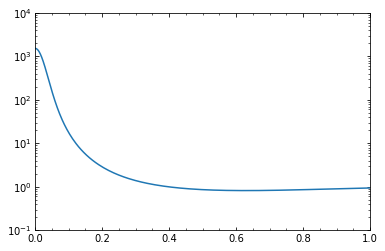

In [3034]:
plt.plot((ms.Abar*ms.R * np.exp((ms.alpha-1) * ms.xi)), ms.rho(ms.R,ms.m))
plt.xlim(0,1)
plt.yscale('log')
plt.ylim(1e-1,1e4)

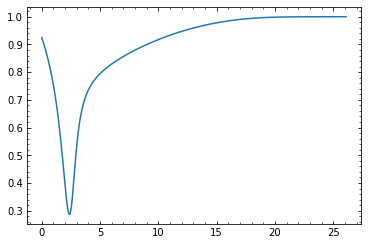

In [2434]:
plt.plot(ms.Abar[0:ms.N-1], ms.U_hm)

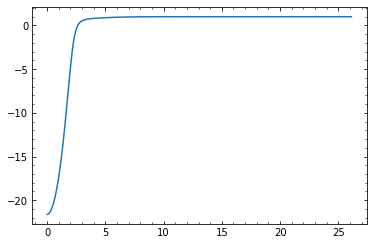

In [3033]:
plt.plot(ms.Abar, ms.U)

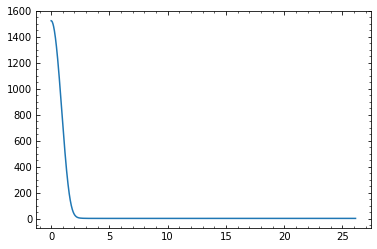

In [3032]:
plt.plot(ms.Abar, ms.rho(ms.R,ms.m))

In [55]:
ms.run_steps(53000)

Tracing ray is enabled and excision will be performed!
Photon has gone out of the outter boundary or horizon is identified!


In [19]:
import copy
ms_mix = copy.copy(ms)

In [57]:
import copy
ms_uni = copy.copy(ms)

In [80]:

hm_uni = HM(ms_uni)

In [115]:
hm_mix = HM(ms_mix)

In [2304]:
#hm_mix.run_steps(2000)
hm=hm_mix

In [111]:
hm_uni.run_steps(100)
hm=hm_uni

In [ ]:
hm_mix.run_steps(40000)
hm=hm_mix

In [110]:
hm_uni=copy.copy(hm_uni_bak)

In [101]:
hm_uni_bak=copy.copy(hm_uni)

In [129]:
hm_mix_bak=copy.copy(hm_mix)

In [1915]:
hm_mix = copy.copy(hm_mix_bak)

In [1358]:
(hm_mix_bak.u -hm_mix.u)/ hm_mix.deltau_i

400.0000000024015

In [1928]:
hm_mix.u/hm_mix.deltau_i*2

111200.00000009153

In [2019]:
hm.u=0

In [761]:
hm_uni.u

759.1217309588485

(0.0, 20.0)

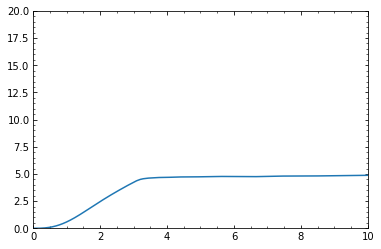

In [3069]:
a = np.exp(hm.alpha * hm.xi)
H = np.exp(-hm.xi) / hm.RH
rho_b = a**(1+hm.w)
Rb = a * hm.A
plt.plot(hm.R * Rb ,  (np.exp(-hm.xi/2) * hm.R **3 * hm.Abar**3 * hm.m ) / 2 )
plt.xlim(0,10)
plt.ylim(0,20)
#plt.yscale('log')

In [1334]:
hm_mix.U.argmin()

206

In [1343]:
hm_mix.Abar[600] - hm_mix.Abar[599]

0.019285079723344367

(0.2, 1.0)

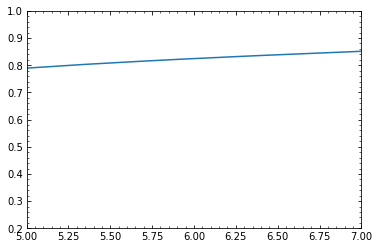

In [2248]:
plt.plot((hm_mix.Abar), hm_mix.U)
#plt.plot((hm_uni.Abar), hm_uni.U)



plt.xlim(5,7)
plt.ylim(0.2,1)
#plt.yscale('log')

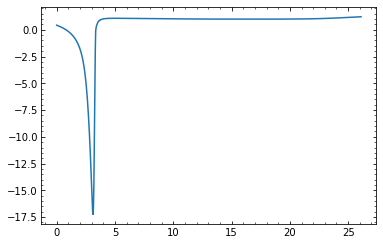

In [112]:
plt.plot((hm.Abar), hm.U)
#plt.plot((hm_uni.Abar), hm_uni.U)



#plt.xlim(20,28)
#plt.ylim(-0.95,1.2)
#plt.yscale('log')

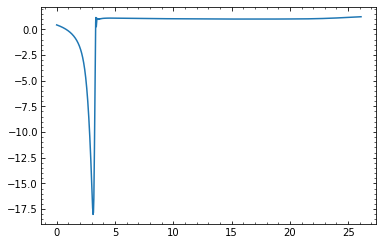

In [3052]:
plt.plot((hm.Abar), hm.U)
#plt.plot((hm_uni.Abar), hm_uni.U)



#plt.xlim(20,28)
#plt.ylim(-0.95,1.2)
#plt.yscale('log')

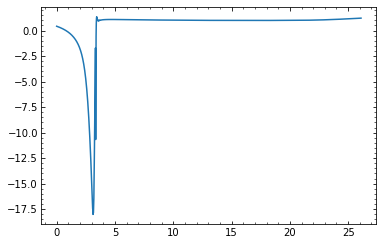

In [78]:
plt.plot((hm_uni.Abar), hm_uni.U)
#plt.plot((hm_uni.Abar), hm_uni.U)



#plt.xlim(0,5)
#plt.ylim(-60,10)
#plt.yscale('log')

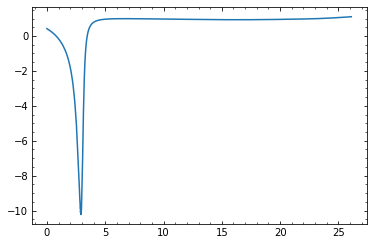

In [128]:
plt.plot((hm_mix.Abar), hm_mix.U)
#plt.plot((hm_uni.Abar), hm_uni.U)



#plt.xlim(0,5)
#plt.ylim(-60,10)
#plt.yscale('log')

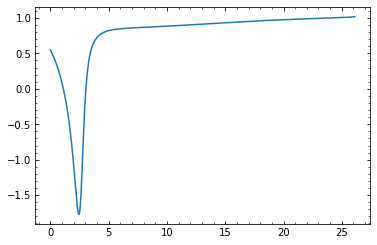

In [119]:
plt.plot((hm_mix.Abar), hm_mix.U)
#plt.plot((hm_uni.Abar), hm_uni.U)



#plt.xlim(0,5)
#plt.ylim(-60,10)
#plt.yscale('log')

In [2081]:
hm_mix.U[0]

0.42428029657515964

(-60.0, 10.0)

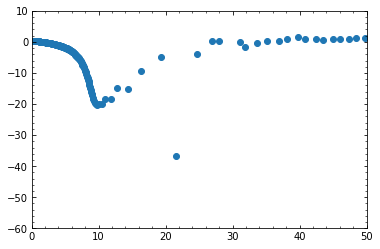

In [3066]:
plt.scatter((hm.Abar*hm.R * np.exp((hm.alpha) * hm.xi)), hm.U)
#plt.plot((hm_uni.Abar), hm_uni.U)



plt.xlim(0,50)
plt.ylim(-60,10)
#plt.yscale('log')

In [ ]:
hm_mix

In [2116]:
hm_mix_bak_low.Abar[-1]

31.831053572039675

In [2115]:
hm_mix.Abar[-1]

26.09068536931808

(0.0, 54.0)

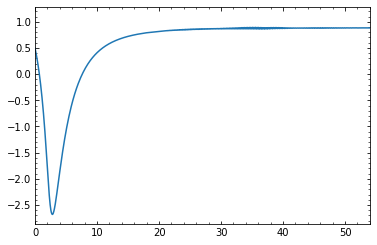

In [2123]:
plt.plot((hm_mix.Abar*hm_mix.R * np.exp((hm_mix.alpha) * hm_mix.xi))*hm_mix.RH, hm_mix.U)
#plt.plot((hm_uni.Abar), hm_uni.U)



plt.xlim(0,54)
#plt.ylim(-60,10)
#plt.yscale('log')

In [1490]:
ms=ms_mix_cubic

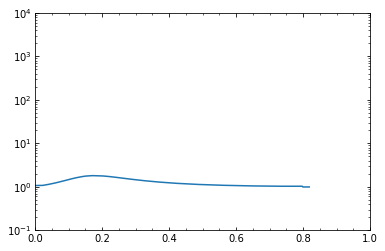

In [1614]:
plt.plot((ms.Abar*ms.R * np.exp((ms.alpha-1) * ms.xi)), ms.rho(ms.R,ms.m))

plt.ylim(1e-1,1e4)
plt.xlim(0,1)
plt.yscale('log')

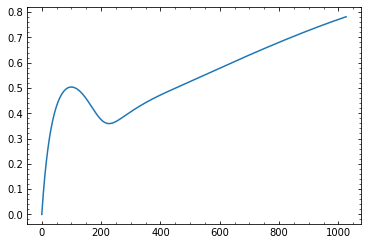

In [1896]:
plt.plot((hm_mix.Abar*hm_mix.R * np.exp((hm_mix.alpha-1) * hm_mix.xi)))



(1470.0, 1500.0)

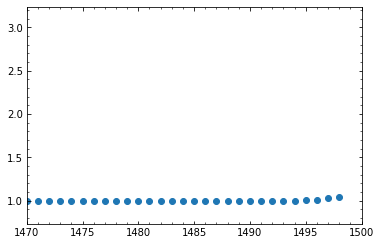

In [2692]:
plt.scatter(np.arange(hm.N), r)

#plt.ylim(0.5,1)
plt.xlim(1470,1500)

(0.0, 30.0)

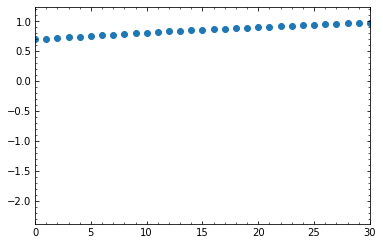

In [2563]:
plt.scatter(np.arange(hm.N), WENO_dfdA(r, hm.deltaL, hm.Abar, 1e100)[:])

#plt.ylim(0.5,1)
plt.xlim(0,30)

(0.0, 30.0)

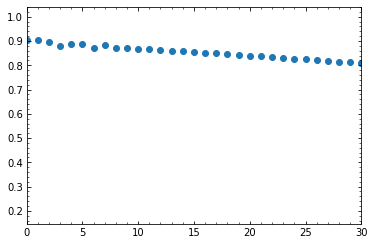

In [2876]:
plt.scatter(np.arange(hm.N), hm.U)

#plt.ylim(0.5,1)
plt.xlim(0,30)

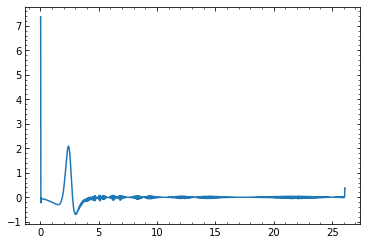

In [2560]:
        xiprime = dfdA(hm.xi, hm.deltaL, hm.Abar, 1e100)
        Rprime = dfdA(hm.R, hm.deltaL, hm.Abar, 1e100)
        mprime = dfdA(hm.m, hm.deltaL, hm.Abar, 1e100)


        
        #xiprime.fill(1)
        
        g = hm.gamma(hm.R, hm.m, hm.U)
        r = hm.rho(hm.R, hm.m, hm.U, hm.xi, g, xiprime, Rprime, mprime)
        drho = hm.drho(hm.R, hm.m, hm.U, g, hm.xi, Rprime, mprime, xiprime)
        exi = np.exp(hm.xi)
        ephi = hm.ephi(hm.R, hm.U, g, hm.xi, xiprime, Rprime)
        elambda = hm.elambda(ephi, exi, xiprime)
        epsi = hm.epsi(hm.R, hm.U, g, hm.xi, r, ephi)
        
        plt.plot(hm.Abar[2:], ddfddA(hm.U, hm.deltaL, hm.Abar, 0)[2:])
        #plt.plot(np.arange(hm.N), dfdA(r, hm.deltaL, hm.Abar, 1e100))
        #plt.plot((hm_mix.Abar*hm_mix.R * np.exp((hm_mix.alpha) * hm_mix.xi)), r* (np.exp((hm_mix.alpha) * hm_mix.xi))**(-3*(1+w)))
        #plt.plot(np.arange(hm.N), ephi)
        #plt.plot(np.arange(hm.N), epsi)
        #plt.plot(np.arange(hm.N),elambda / epsi)
        #plt.xlim(0.1,3)
        #plt.ylim(-0.1,0)
        #plt.yscale('log')
#plt.ylim(0.915,0.93)

In [2083]:
 epsi[0] / elambda[0] * (hm.U[1] - hm.U[0]) / ( (hm.Abar[1] - hm.Abar[0]) )

-6.108149663452625e-06

In [2197]:
hm=hm_mix_bak
hm_mix = hm_mix_bak

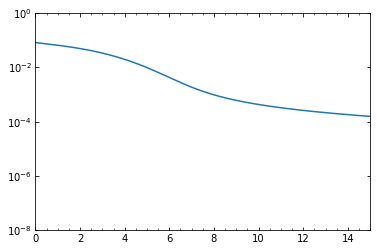

In [2200]:
        xiprime = dfdA(hm.xi, hm.deltaL, hm.Abar, 1e100)
        Rprime = dfdA(hm.R, hm.deltaL, hm.Abar, 1e100)
        mprime = dfdA(hm.m, hm.deltaL, hm.Abar, 1e100)


        
        #xiprime.fill(1)
        
        g = hm.gamma(hm.R, hm.m, hm.U)
        r = hm.rho(hm.R, hm.m, hm.U, hm.xi, g, xiprime, Rprime, mprime)
        drho = hm.drho(hm.R, hm.m, hm.U, g, hm.xi, Rprime, mprime, xiprime)
        exi = np.exp(hm.xi)
        ephi = hm.ephi(hm.R, hm.U, g, hm.xi, xiprime, Rprime)
        elambda = hm.elambda(ephi, exi, xiprime)
        epsi = hm.epsi(hm.R, hm.U, g, hm.xi, r, ephi)
        
        #plt.plot(np.arange(hm.N-1), ddfddA(hm.U, hm.deltaL, hm.Abar, 0)[1:])
        #plt.plot(np.arange(hm.N), dfdA(r, hm.deltaL, hm.Abar, 1e100))
        plt.plot((hm_mix.Abar*hm_mix.R * np.exp((hm_mix.alpha) * hm_mix.xi)), r* (np.exp((hm_mix.alpha) * hm_mix.xi))**(-3*(1+w)))
        #plt.plot(np.arange(hm.N), ephi)
        #plt.plot(np.arange(hm.N), epsi)
        #plt.plot(np.arange(hm.N),elambda / epsi)
        plt.xlim(0,15)
        plt.ylim(1e-8,1)
        plt.yscale('log')
#plt.ylim(0.915,0.93)

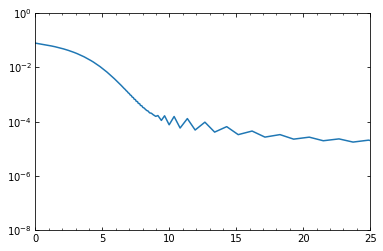

In [2084]:
        xiprime = dfdA(hm.xi, hm.deltaL, hm.Abar, 1e100)
        Rprime = dfdA(hm.R, hm.deltaL, hm.Abar, 1e100)
        mprime = dfdA(hm.m, hm.deltaL, hm.Abar, 1e100)


        
        #xiprime.fill(1)
        
        g = hm.gamma(hm.R, hm.m, hm.U)
        r = hm.rho(hm.R, hm.m, hm.U, hm.xi, g, xiprime, Rprime, mprime)
        drho = hm.drho(hm.R, hm.m, hm.U, g, hm.xi, Rprime, mprime, xiprime)
        exi = np.exp(hm.xi)
        ephi = hm.ephi(hm.R, hm.U, g, hm.xi, xiprime, Rprime)
        elambda = hm.elambda(ephi, exi, xiprime)
        epsi = hm.epsi(hm.R, hm.U, g, hm.xi, r, ephi)
        
        #plt.plot(np.arange(hm.N-1), ddfddA(hm.U, hm.deltaL, hm.Abar, 0)[1:])
        #plt.plot(np.arange(hm.N), dfdA(r, hm.deltaL, hm.Abar, 1e100))
        plt.plot((hm_mix.Abar*hm_mix.R * np.exp((hm_mix.alpha) * hm_mix.xi)), r* (np.exp((hm_mix.alpha) * hm_mix.xi))**(-3*(1+w)))
        #plt.plot(np.arange(hm.N), ephi)
        #plt.plot(np.arange(hm.N), epsi)
        #plt.plot(np.arange(hm.N),elambda / epsi)
        plt.xlim(0,25)
        plt.ylim(1e-8,1)
        plt.yscale('log')
#plt.ylim(0.915,0.93)

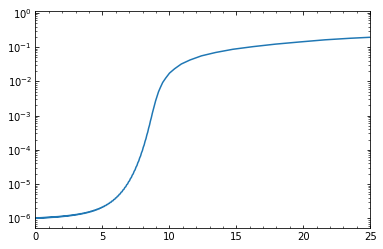

In [113]:
        xiprime = dfdA(hm.xi, hm.deltaL, hm.Abar, 1e100)
        Rprime = dfdA(hm.R, hm.deltaL, hm.Abar, 1e100)
        mprime = dfdA(hm.m, hm.deltaL, hm.Abar, 1e100)


        
        #xiprime.fill(1)
        
        g = hm.gamma(hm.R, hm.m, hm.U)
        r = hm.rho(hm.R, hm.m, hm.U, hm.xi, g, xiprime, Rprime, mprime)
        drho = hm.drho(hm.R, hm.m, hm.U, g, hm.xi, Rprime, mprime, xiprime)
        exi = np.exp(hm.xi)
        ephi = hm.ephi(hm.R, hm.U, g, hm.xi, xiprime, Rprime)
        elambda = hm.elambda(ephi, exi, xiprime)
        epsi = hm.epsi(hm.R, hm.U, g, hm.xi, r, ephi)
        
        #plt.plot(np.arange(hm.N-1), ddfddA(hm.U, hm.deltaL, hm.Abar, 0)[1:])
        #plt.plot(np.arange(hm.N), dfdA(r, hm.deltaL, hm.Abar, 1e100))
        plt.plot((hm.Abar*hm.R * np.exp((hm.alpha) * hm.xi)), epsi)
        #plt.plot(np.arange(hm.N), ephi)
        #plt.plot(np.arange(hm.N), epsi)
        #plt.plot(np.arange(hm.N),elambda / epsi)
        plt.xlim(0,25)
        #plt.ylim(1e-8,1)
        plt.yscale('log')
#plt.ylim(0.915,0.93)

In [779]:
hm_uni.u

759.1217309588485

In [1295]:
hm_mix.u

392.8628124890612

In [782]:
(hm_mix.R**2 * hm_mix.m * hm_mix.Abar**2 * np.exp(2*(hm_mix.alpha-1)*hm_mix.xi)).max()

0.9634685108540257

In [1313]:
(hm_uni.R**2 * hm_uni.m * hm_uni.Abar**2 * np.exp(2*(hm_uni.alpha-1)*hm_uni.xi)).max()

0.7090729472399385

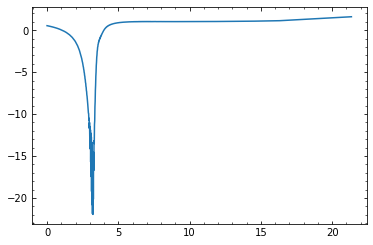

In [1312]:
plt.plot(hm_mix.Abar[:], hm_mix.U[:])
#plt.plot(hm_bak.Abar[:], hm_bak.U[:])


#plt.xlim(0,30)
#plt.ylim(-10,-19.5)

In [114]:
(hm.R**2 * hm.m * hm.Abar**2 * np.exp(2*(hm.alpha-1)*hm.xi)).max()

0.9703072192421069

(0.0, 1.0)

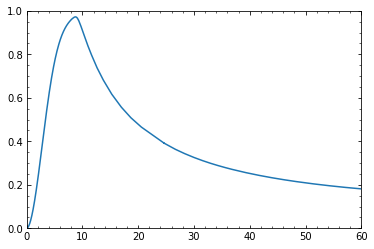

In [2990]:
plt.plot((hm.Abar*hm.R * np.exp((hm.alpha) * hm.xi)), hm.R**2 * hm.m * hm.Abar**2 * np.exp(2*(hm.alpha-1)*hm.xi))
#plt.plot(hm.Abar, hm_bak.R**2 * hm_bak.m * hm_bak.Abar**2 * np.exp(2*(hm_bak.alpha-1)*(hm_bak.xi)))

plt.xlim(0,60)
plt.ylim(0.,1)

/tmp/ipykernel_1959/3040225057.py:50: RuntimeWarning: divide by zero encountered in true_divide
  return (self.alpha * xiprime * self.Abar * R + self.Abar * Rprime + R) \
/tmp/ipykernel_1959/3040225057.py:57: RuntimeWarning: invalid value encountered in multiply
  c = self.alpha - 1 + ephi * self.Abar * R * rho * (1 + self.w) /\


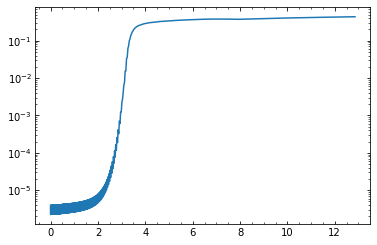

In [786]:
        xiprime = dfdA(hm.xi, hm.deltaL, hm.Abar, 0)
        Rprime = dfdA(hm.R, hm.deltaL, hm.Abar, 0)
        mprime = dfdA(hm.m, hm.deltaL, hm.Abar, 0)
        Uprime = dfdA(hm.U, hm.deltaL, hm.Abar, 0)
        #print((xiprime ))
        g = hm.gamma(hm.R, hm.m, hm.U)
        r = hm.rho(hm.R, hm.m, hm.U, hm.xi, g, xiprime, Rprime, mprime)
        p = hm.P(r)
        exi = np.exp(hm.xi)
        ephi = hm.ephi(hm.R, hm.U, g, xiprime, Rprime)
        
        epsi = hm.epsi(hm.R, hm.U, g, hm.xi, r, ephi)
        plt.plot(hm.Abar, epsi)
        plt.yscale('log')

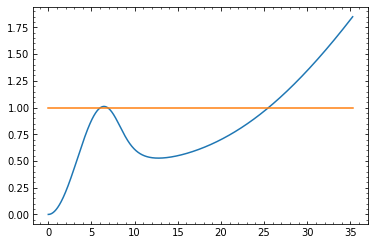

In [1652]:
plt.plot(ms.Abar, ms_bak.R**2 * ms_bak.m * ms_bak.Abar**2 * np.exp(2 * (ms_bak.alpha-1) * ms_bak.xi))
plt.plot(ms.Abar, np.array([1]*ms.N))
#plt.xlim(0,4)

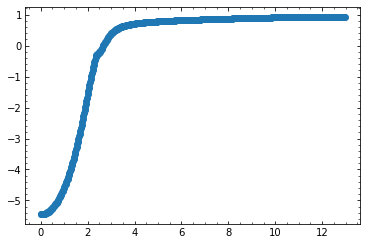

In [185]:
plt.scatter(Abar[:], ms.U[:])
#plt.xlim(0,30)
#plt.ylim(0,1)

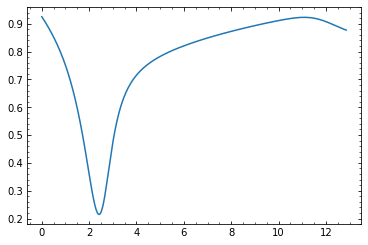

In [707]:
plt.plot(ms_mix.Abar[:ms_mix.N-1], ms_mix.U_hm[:ms_mix.N-1])



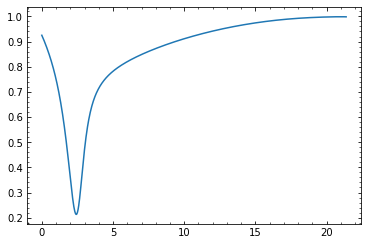

In [811]:
plt.plot(ms.Abar[:ms.N-1], ms.U_hm[:ms.N-1])



In [194]:
hm.deltau_i

0.038651819295227194

In [618]:
import copy
ms_std = copy.copy(ms)

In [665]:
ms = copy.copy(ms_std)

In [1026]:
hm = HM(ms)

In [7]:
hm.run_steps(2000)

NameError: name 'hm' is not defined

In [820]:
import copy
hm_bak = copy.copy(hm)

In [933]:
import copy
hm_bak2 = copy.copy(hm)

In [1009]:
hm = copy.copy(hm_bak2)

In [977]:
import copy
hm_bak3 = copy.copy(hm)

In [953]:
hm.u / hm.deltau_i / 10

142219.99999575678

(0.0, 10.0)

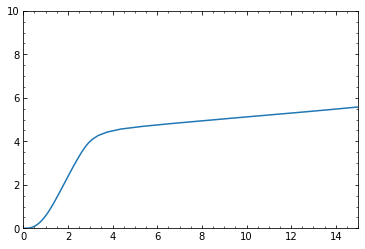

In [1024]:
a = np.exp(hm.alpha * hm.xi)
H = np.exp(-hm.xi) / hm.RH
rho_b = a**(1+hm.w)
Rb = a * hm.A
plt.plot(hm.R * Rb ,  (np.exp(-hm.xi/2) * hm.R **3 * hm.Abar**3 * hm.m ) / 2 )
plt.xlim(0,15)
plt.ylim(0,10)
#plt.yscale('log')

In [ ]:
plt.plot(hm.Abar, hm.m)
plt.plot(hm_bak.Abar, hm_bak.m)


#plt.xlim(0,300)

(0.0, 300.0)

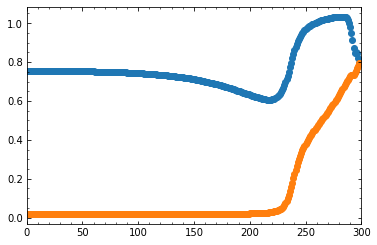

In [784]:
        xiprime = dfdA(hm.xi, hm.deltaL, hm.Abar, 0)
        Rprime = dfdA(hm.R, hm.deltaL, hm.Abar, 0)
        mprime = dfdA(hm.m, hm.deltaL, hm.Abar, 0)


        
        #xiprime.fill(1)
        
        g = hm.gamma(hm.R, hm.m, hm.U)
        r = hm.rho(hm.R, hm.m, hm.U, hm.xi, g, xiprime, Rprime, mprime)
        exi = np.exp(hm.xi)
        ephi = hm.ephi(hm.R, hm.U, g, xiprime, Rprime)
        elambda = hm.elambda(ephi, exi, xiprime)
        epsi = hm.epsi(hm.R, hm.U, g, hm.xi, r, ephi)
        plt.scatter(np.arange(hm.N), ephi)
        plt.scatter(np.arange(hm.N), epsi)
        plt.xlim(0,300)
#plt.ylim(0.915,0.93)

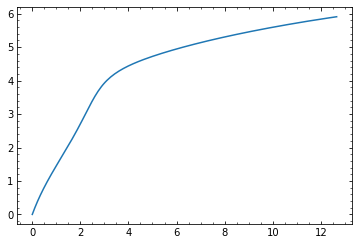

In [832]:
plt.plot(hm.Abar,  hm.xi-0)


#plt.xlim(0,300)
#plt.ylim(0.915,0.93)

In [1012]:
( hm.R**2 * hm.m * hm.Abar**2 * np.exp(2*(hm.alpha-1)*hm.xi)).max()

0.9326803234148633

(0.0, 1.0)

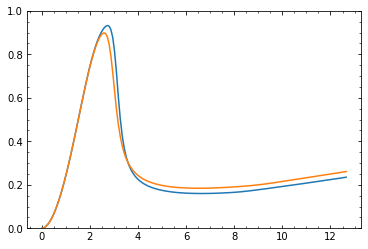

In [1011]:
plt.plot(hm.Abar, hm.R**2 * hm.m * hm.Abar**2 * np.exp(2*(hm.alpha-1)*hm.xi))
plt.plot(hm.Abar, hm_bak.R**2 * hm_bak.m * hm_bak.Abar**2 * np.exp(2*(hm_bak.alpha-1)*(hm_bak.xi)))


#plt.xlim(0,300)
plt.ylim(0.,1)

In [ ]:
plt.plot(hm.Abar, hm.R**2 * hm.m * hm.A**2 * np.exp(2*(hm.alpha-1)*hm.xi))
plt.plot(hm.Abar, hm_bak.R**2 * hm_bak.m * hm_bak.A**2 * np.exp(2*(hm_bak.alpha-1)*hm_bak.xi))


#plt.xlim(0,300)
#plt.ylim(0.915,0.93)

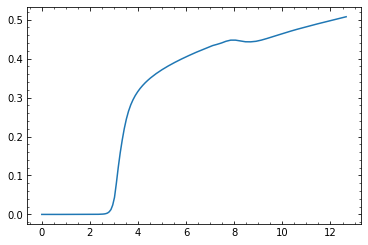

In [1010]:
        xiprime = dfdA(hm.xi, hm.deltaL, hm.Abar, 0)
        Rprime = dfdA(hm.R, hm.deltaL, hm.Abar, 0)
        mprime = dfdA(hm.m, hm.deltaL, hm.Abar, 0)
        Uprime = dfdA(hm.U, hm.deltaL, hm.Abar, 0)
        #print((xiprime ))
        g = hm.gamma(hm.R, hm.m, hm.U)
        r = hm.rho(hm.R, hm.m, hm.U, hm.xi, g, xiprime, Rprime, mprime)
        p = hm.P(r)
        exi = np.exp(hm.xi)
        ephi = hm.ephi(hm.R, hm.U, g, xiprime, Rprime)
        
        epsi = hm.epsi(hm.R, hm.U, g, hm.xi, r, ephi)
        plt.plot(hm.Abar, epsi)

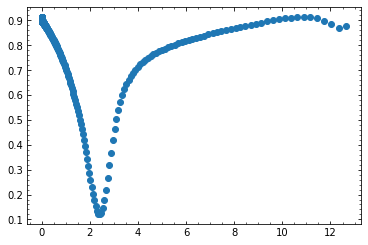

In [763]:
plt.scatter(hm.Abar, hm.U[:])
#plt.xlim(0,30)
#plt.ylim(0,1)

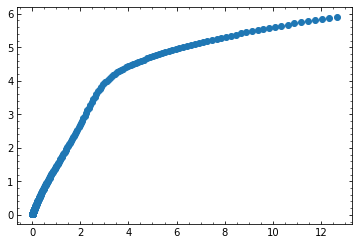

In [884]:
plt.scatter(Abar[:n-1], ms.xi_hm[:])
#plt.xlim(0,30)
#plt.ylim(0,1)

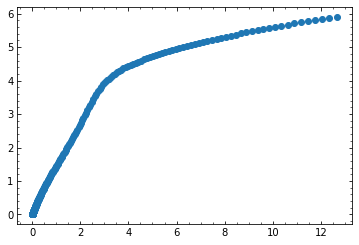

In [883]:
plt.scatter(Abar[:n-1], ms_std.xi_hm[:])
#plt.xlim(0,30)
#plt.ylim(0,1)